# Vineyards Navigation with Semantic Segmentation - All Crops

Using semantic segmentation for a proportional controller along the vineyard rows.




- This notebook contains scripts to create, train, and test a deep learning network to perform fast semantic segmentation on platform with mobile CPUs and low memory capabilities

- The implemented architecture is a MobileNetV3 with a customized LR-ASPP

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cfg Completer.use_jedi = False

UsageError: Line magic function `%cfg` not found.


In [2]:
# Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import sys

sys.path.append(os.path.abspath("../"))
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import glob
import math
import random
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

import tensorflow as tf
import tensorflow_addons as tfa

from utils.tools import *
from utils.preprocess import *
from utils.visualize import *
from utils.training_tools import *
from utils.models import build_model_multi, build_model_binary
#from utils.cityscapes_utils import CityscapesDataset
from utils.mobilenet_v3 import MobileNetV3Large 

2024-07-15 19:55:38.123574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 19:55:38.123599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 19:55:38.124390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [25]:
# define some variables and read cfg
config_path = '../cfg/cfg.yaml'
cfg = read_yaml(config_path)
model_dir = Path(cfg['MODEL_PATH'])
logs_dir = Path(cfg['LOG_PATH'])

cfg

{'GPU': [0],
 'SEED': 0,
 'VERBOSE': False,
 'NAME': None,
 'SAVE_BEST': True,
 'HP_SEARCH': False,
 'HP_SEARCH_NAME': '',
 'HP_SEARCH_DIR': 'trials',
 'N_TRIALS': 8,
 'CITYSCAPES': False,
 'ROOT': '../../AgriSeg_dataset_complete/AgriSeg_Dataset/',
 'CROPS': ['Synthetic_Dataset_Vineyard_pergolato',
  'Synthetic_Dataset_Extreme'],
 'SUBSAMPLE': True,
 'NORM': 'tf',
 'STYLE_AUG': False,
 'RND_FLIP': 0.5,
 'RND_CROP': 0.5,
 'RND_GREY': 0.1,
 'RND_JITTER': 1.0,
 'RND_JITTER_RNG': 0.4,
 'ZCA': False,
 'WCTA': False,
 'FWCTA': False,
 'DATA_PATH': '/ssd1/sa58728/AgriSeg_Dataset/',
 'MODEL_PATH': '../bin/',
 'LOG_PATH': '../logs/',
 'IMG_SIZE_TEST': [224, 224],
 'IMG_SIZE': 224,
 'SPLIT_SIZE': 0.1,
 'BATCH_SIZE': 64,
 'N_CLASSES': 1,
 'N_EPOCHS': 50,
 'FREEZE_BACKBONE': False,
 'LOSS': 'bce',
 'METRIC': 'iou',
 'OPTIMIZER': 'adamw',
 'SGD': {'LR': '1e-2', 'MOMENTUM': 0.8, 'DECAY': 0.1, 'NESTEROV': False},
 'ADAM': {'LR': '3e-4'},
 'ADAMW': {'LR': '5e-5', 'LR_END': '5e-6', 'DECAY': 1, 'WD': '1

In [26]:
# define dataset import paths
ROOT = Path(cfg['ROOT'])
DATASETS = sorted([ROOT.joinpath(d) for d in os.listdir(ROOT)
                   if not d.startswith('.') and not d.endswith('.yaml')])

In [6]:
CROPS = cfg['CROPS']
DATASETS = sorted([ROOT.joinpath(d) for d in CROPS])
DATASETS

[PosixPath('../../AgriSeg_dataset_complete/AgriSeg_Dataset/Synthetic_Dataset_Extreme'),
 PosixPath('../../AgriSeg_dataset_complete/AgriSeg_Dataset/Synthetic_Dataset_Vineyard_pergolato')]

# Pre-process the dataset

In [8]:
from utils.data import load_dataset

def load_datasets(datasets, cfg):
    for crop in datasets:
        if 'ds' in locals():
            ds = ds.concatenate(load_dataset(crop, cfg))
        else:
            ds = load_dataset(crop, cfg)
    return ds

In [9]:
ds = load_datasets(DATASETS, cfg)

../../AgriSeg_dataset_complete/AgriSeg_Dataset/Synthetic_Dataset_Extreme/bieta.dataset
Found 240 files belonging to 1 classes.
Found 240 files belonging to 1 classes.


../../AgriSeg_dataset_complete/AgriSeg_Dataset/Synthetic_Dataset_Extreme/bieta.dataset.extreme.1
Found 240 files belonging to 1 classes.
Found 240 files belonging to 1 classes.
../../AgriSeg_dataset_complete/AgriSeg_Dataset/Synthetic_Dataset_Extreme/bieta.dataset.extreme.2
Found 240 files belonging to 1 classes.
Found 240 files belonging to 1 classes.
../../AgriSeg_dataset_complete/AgriSeg_Dataset/Synthetic_Dataset_Extreme/lattuga.dataset
Found 240 files belonging to 1 classes.
Found 240 files belonging to 1 classes.
../../AgriSeg_dataset_complete/AgriSeg_Dataset/Synthetic_Dataset_Extreme/lattuga.dataset.extreme.1
Found 240 files belonging to 1 classes.
Found 240 files belonging to 1 classes.
../../AgriSeg_dataset_complete/AgriSeg_Dataset/Synthetic_Dataset_Extreme/lavanda.dataset
Found 240 files belonging to 1 classes.
Found 240 files belonging to 1 classes.
../../AgriSeg_dataset_complete/AgriSeg_Dataset/Synthetic_Dataset_Extreme/lavanda.dataset.extreme.1
Found 221 files belonging to 1

In [10]:
from utils.data import split_data
ds_train, ds_val, ds_test, train_len, val_len, test_len = split_data(ds, cfg, return_len=True)


In [11]:
ds_train = ds_train.cache()
ds_train = ds_train.map(data_aug)
ds_train = ds_train.batch(cfg['BATCH_SIZE'])
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = ds_val.cache()
ds_val = ds_val.batch(cfg['BATCH_SIZE'])
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.cache()
ds_test = ds_test.batch(cfg['BATCH_SIZE'])
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# VISUALIZE

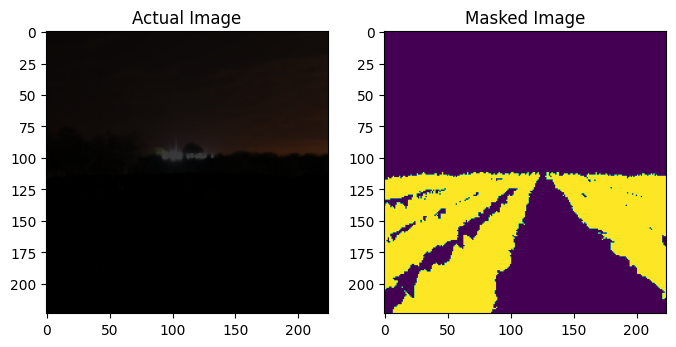

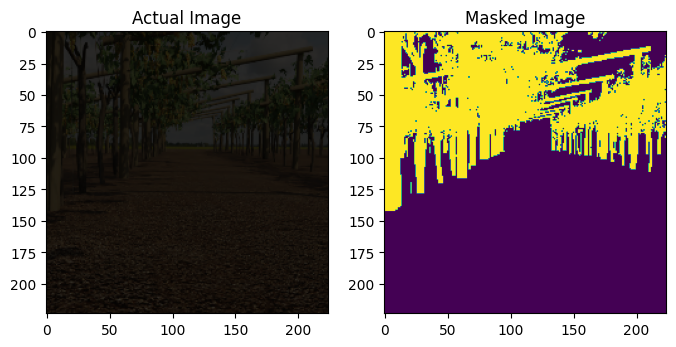

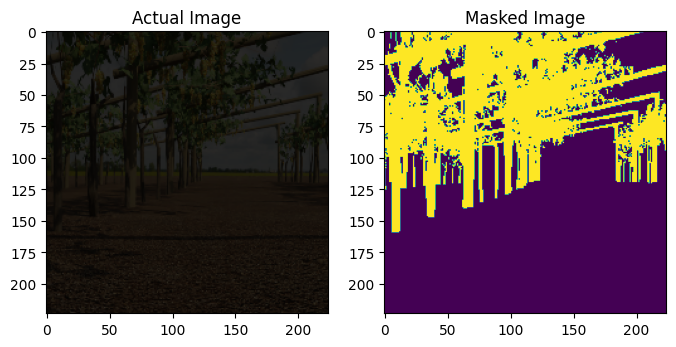

In [13]:
n_images = 3

for img, gt in list(ds_test.unbatch().take(n_images)):
    visualize_images(img, gt, pred=None, denormalize=True, vineyard=True, imagenet=True)

# Create Mobilenet-v3 with LR-ASPP

In [14]:
#base model mobile net

#with mirrored_strategy.scope():
backbone = MobileNetV3Large(input_shape=(cfg['IMG_SIZE'], cfg['IMG_SIZE'], 3),
                            alpha=1.0,
                            minimalistic=False,
                            include_top=False,
                            weights='imagenet',
                            input_tensor=None,
                            classes=cfg['N_CLASSES'],
                            pooling='avg',
                            dropout_rate=0,
                            backend=tf.keras.backend, 
                            layers=tf.keras.layers, 
                            models=tf.keras.models, 
                            utils=tf.keras.utils)

model = build_model_binary(backbone, 0, 1, return_feats=False)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv_pad (ZeroPadding2D)    (None, 225, 225, 3)          0         ['rescaling[0][0]']           
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['Conv_pad[0][0]']            
                                                                                              

# Train the model

In [23]:
name_model = 'lr_aspp_multicrop_adamw_b'+str(cfg['BATCH_SIZE'])+'_binary.h5'

In [17]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=name_model, 
                               monitor = 'val_loss',
                               verbose=1, 
                               save_best_only=True)

total_update_steps = cfg['N_EPOCHS'] * (train_len) // cfg['BATCH_SIZE']

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, 
                                                            decay_steps=total_update_steps, 
                                                            end_learning_rate=1e-6, power=0.96)

In [18]:
adam_w = tfa.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.99, nesterov=False)
adam = tf.keras.optimizers.Adam(learning_rate=3e-4)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss=tf.losses.BinaryCrossentropy(),
              metrics = [mIoU])

In [20]:
# train the model on the new data for a few epochs
history = model.fit(ds_train, validation_data=ds_val,
                    epochs=cfg['N_EPOCHS'],
                    callbacks=[])  

Epoch 1/3


I0000 00:00:1721073477.938208   96530 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 [==============================] - 41s 177ms/step - loss: 0.2241 - mIoU: 0.2862 - val_loss: 0.2140 - val_mIoU: 0.2870
Epoch 2/3
108/108 [==============================] - 7s 65ms/step - loss: 0.1608 - mIoU: 0.2862 - val_loss: 0.2046 - val_mIoU: 0.2870
Epoch 3/3
108/108 [==============================] - 7s 66ms/step - loss: 0.1534 - mIoU: 0.2862 - val_loss: 0.1984 - val_mIoU: 0.2870


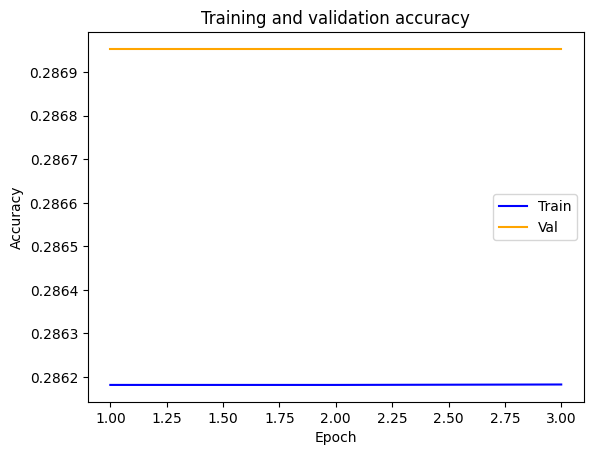

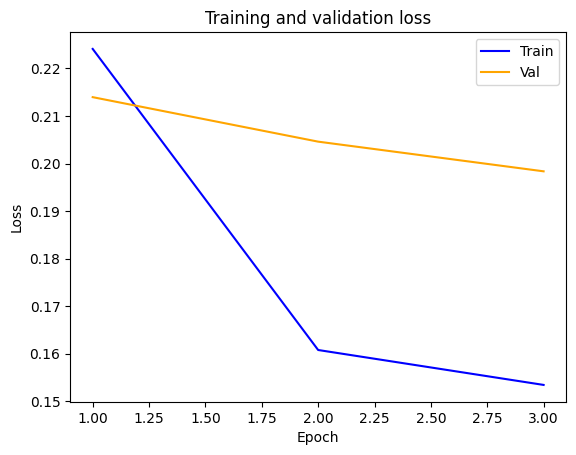

In [21]:
plot_history(history, metric='mIoU')

In [22]:
model.save(name_model)

# Test the Model

## Test on test set with training metrics

In [28]:
name_model = 'lr_aspp_multicrop_'+str(cfg['OPTIMIZER'])+'_b'+str(cfg['BATCH_SIZE'])+'_binary.h5'
model.load_weights(model_dir.joinpath(name_model))

In [29]:
model.evaluate(ds_test)

12/12 [==============================] - 9s 31ms/step - loss: 0.1921 - mIoU: 0.2868


[0.1920936405658722, 0.2868035137653351]

## Test on some samples

1/1 [==============================] - 0s 11ms/step


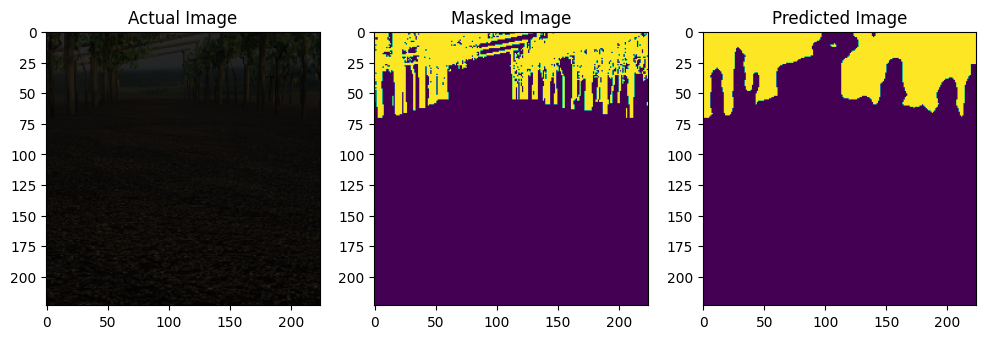

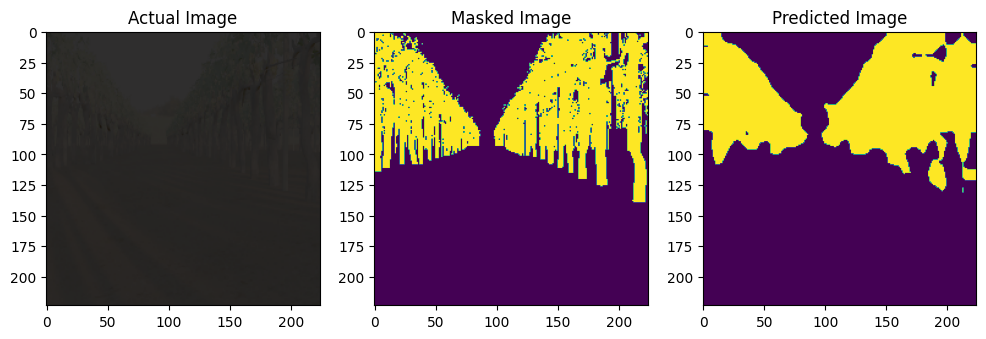

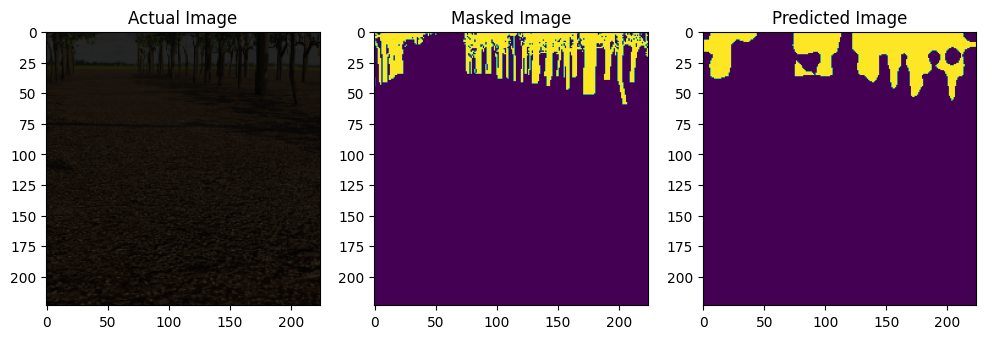

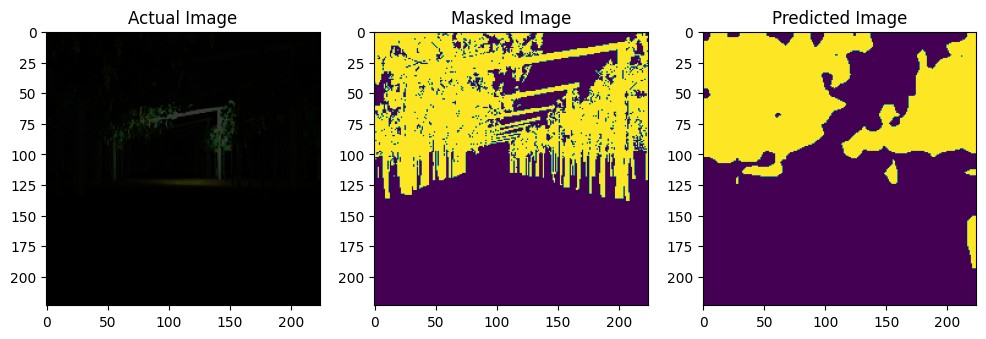

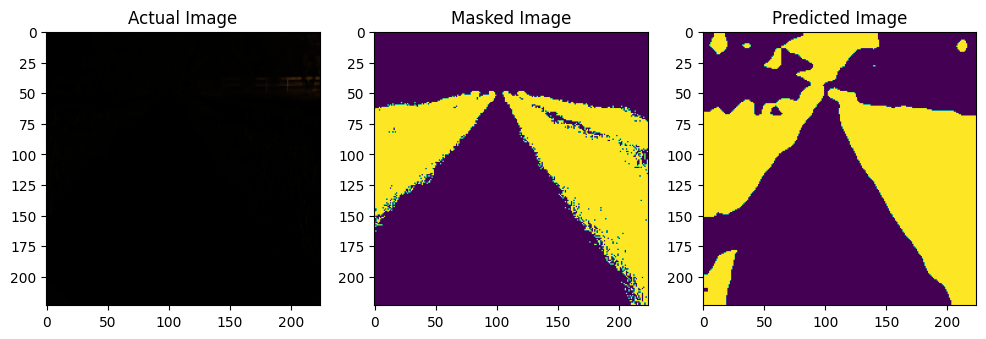

In [30]:
n_images = 5

for img, gt in list(ds_test.unbatch().take(n_images)):
    #print(img.shape)
    #print(gt)
    pred = predict_model_binary(model, img, 0.5).astype(float)
    visualize_images(img, gt, pred[0,...,0], denormalize=True, vineyard=True, imagenet=True)

# Optimize and save tflite model

In [ ]:
raise

In [31]:
model_path = model_dir.joinpath(name_model)

In [32]:
model_path

PosixPath('../bin/lr_aspp_multicrop_adamw_b64_binary.h5')

In [33]:
from utils.mobilenet_v3 import *

model.load_weights(str(model_path))
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("segmentation.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdz3exfai/assets


INFO:tensorflow:Assets written to: /tmp/tmpdz3exfai/assets
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 118, Total Ops 243, % non-converted = 48.56 %
 * 118 ARITH ops

- arith.constant:  118 occurrences  (f32: 105, i32: 13)



  (f32: 10)
  (f32: 1)
  (f32: 39)
  (f32: 12)
  (f32: 14)
  (f32: 2)
  (f32: 5)
  (f32: 12)
  (i32: 5)
  (f32: 4)
  (f32: 5)
  (f32: 3)
  (i32: 5)
  (i32: 5)


4190184

In [34]:
#define functions to import and use tflite model
def input_tensor(interpreter):
    """Returns input tensor view as numpy array of shape (height, width, 3)."""
    tensor_index = interpreter.get_input_details()[0]['index']
    return interpreter.tensor(tensor_index)()[0]

def output_tensor(interpreter):
    """Returns dequantized output tensor."""
    output_details = interpreter.get_output_details()[0]
    output_data = interpreter.tensor(output_details['index'])()
    return output_data

def setInput(interpreter, data):
    """Copies data to input tensor."""
    input_tensor(interpreter)[:, :] = data

In [35]:
interpreter = tf.lite.Interpreter('segmentation.tflite')
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


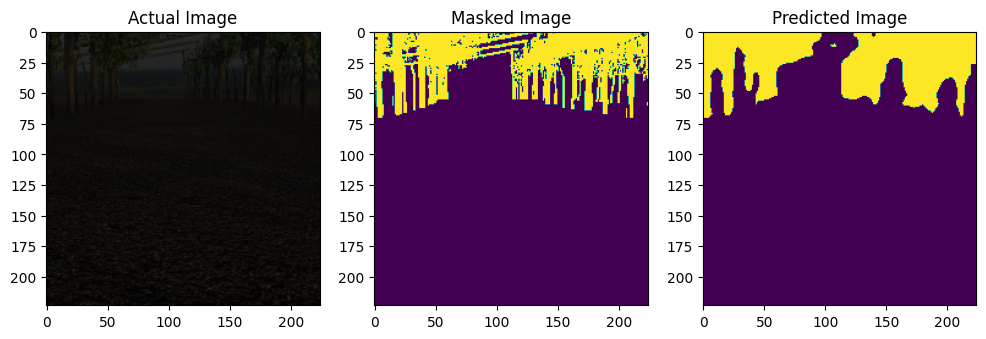

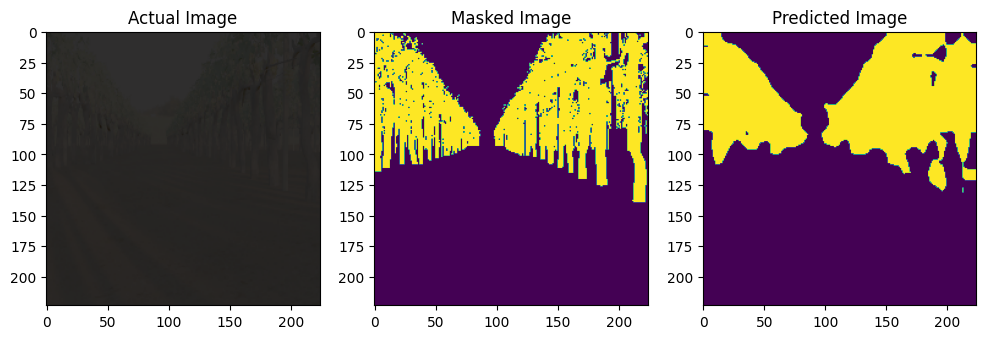

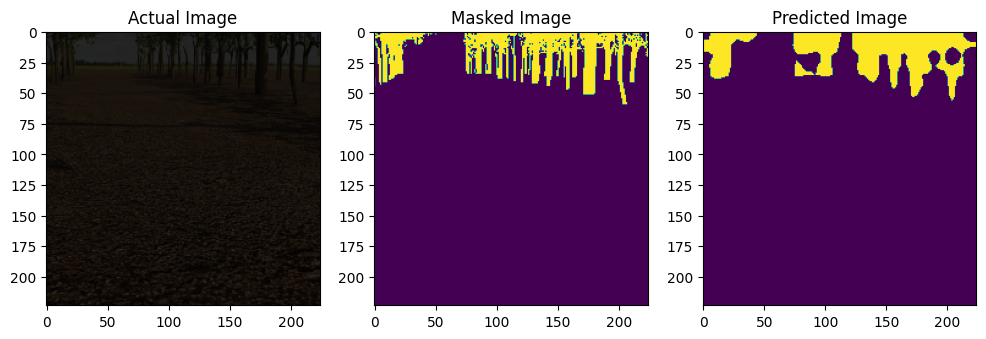

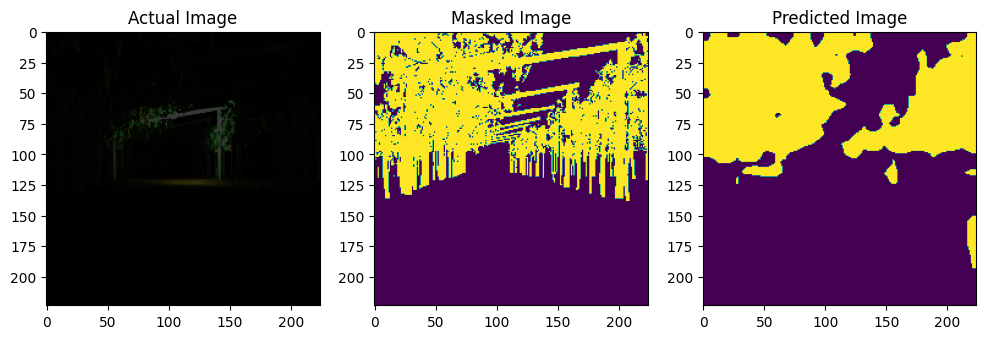

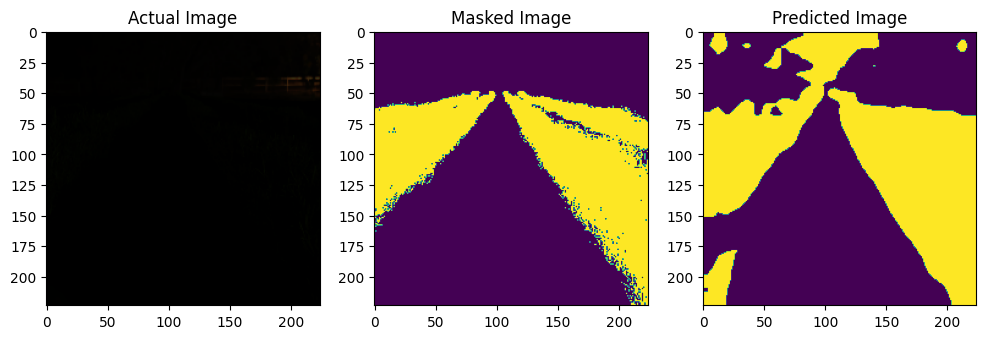

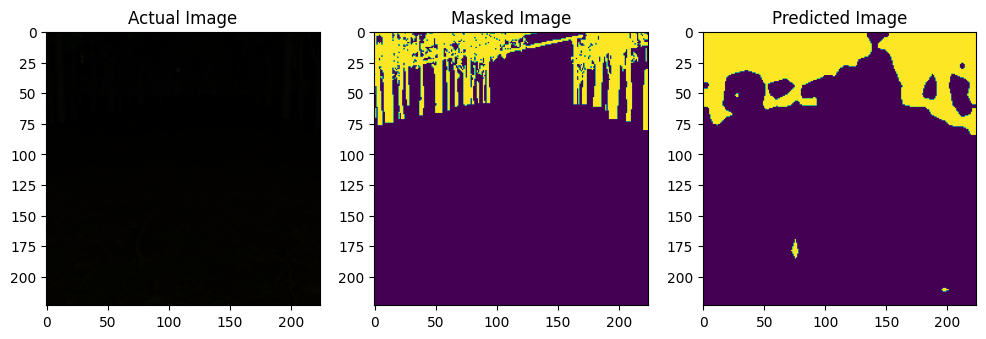

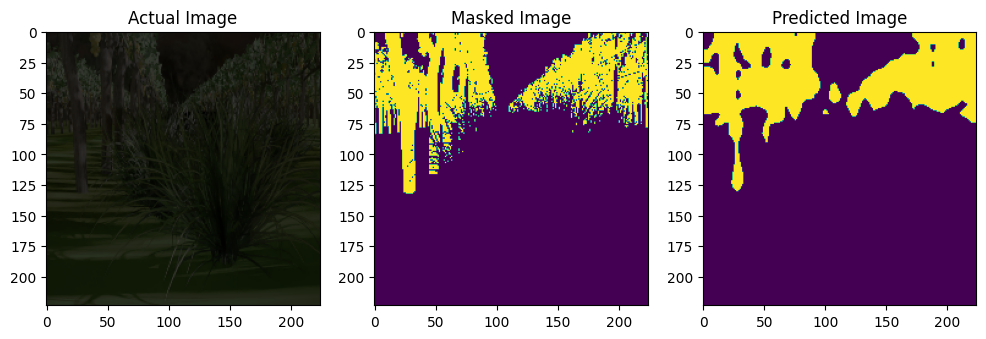

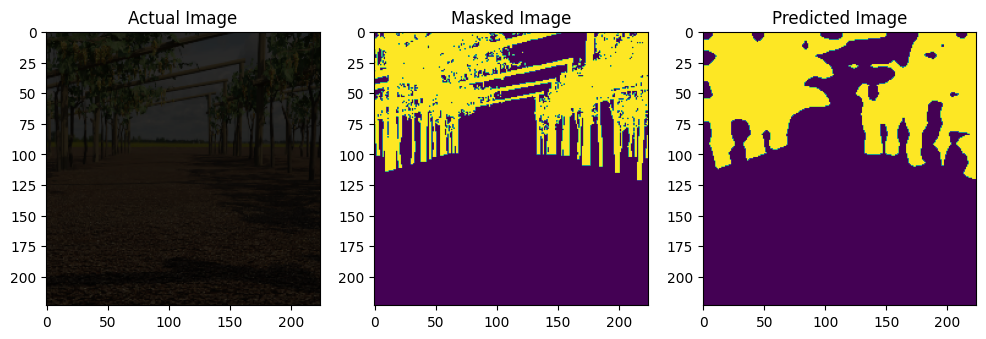

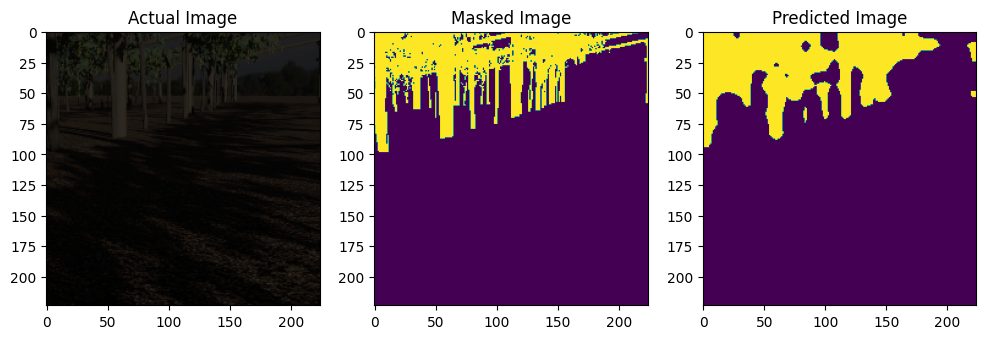

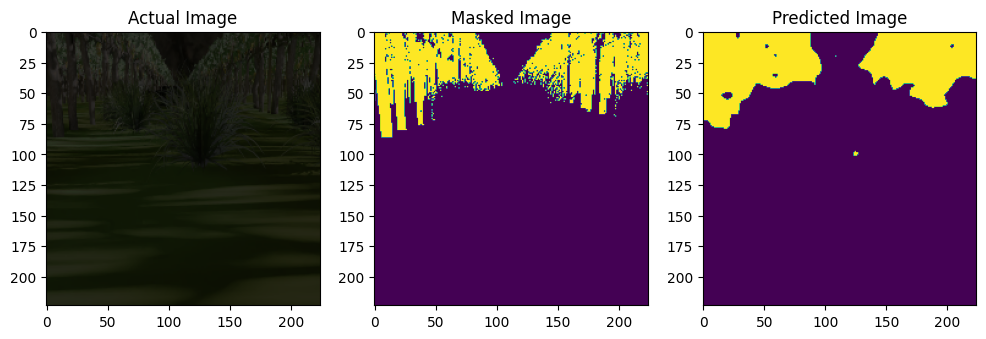

In [45]:
n_images = 10

for img, gt in list(ds_test.unbatch().take(n_images)):
    #print(img.shape)
    #print(gt.shape)
    #model input
    setInput(interpreter, img[None,...])
    # invoke interpreter
    interpreter.invoke()
    y_pred = output_tensor(interpreter)[0]
    y_pred = (y_pred > 0.5)
    #print(y_pred.shape)
    visualize_images(img, gt, y_pred)